# Objective

Test functions for producing arrow maps from relations with dataframes containing a column for location and a column for date.

# Functions in this notebook

### arrow_map()
(created 12/17, debugged 12/22)

Inputs:
- KNP SPARQL relation
- string name of column that contains dates
- string name of column that contains coordinates
- string name of column that contains entity names
- string title of map

Outputs:
- plots arrow map for those coordinates and dates
- prints a "travel log"


### get_random_dates()
(created 12/17)

Inputs:
- string date 1 yyyy-mm-dd
- string date 2 yyyy-mm-dd
- int quantity of random dates to output

Output:
- list of random string yyyy-mm-dd dates

### parse_date()
(created 12/21)

Input:
- string 20-character wikidata format
- OR string 10-character yyyy-mm-dd format

Output:
- string 10-character yyyy-mm-dd format

### parse_lon_lat()

Input:
- string containing longitude, latitude, and other extraneous characters
- OR longitude latitude tuple

Output:
- (float longitude, float latitude) tuple

# Examples

- Example 1: Courthouses in Virginia
- Example 2: National Parks in the US
- Example 3: City Halls in Massachusetts
- Example 4: Museums in Michigan
- Example 5: Museums Around the World

In [1]:
import func_lib, sys, datetime, random, geopandas, warnings
import geopandas as gpd
import numpy as np
import pandas as pd
import shapefile as shp
from shapely.geometry import Point
import matplotlib.patches as patches
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
!{sys.executable} -m pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"
item = "item"

class Relation:
    """
    The class returned when createRelation is called.
    It contains string field with query.
    We call Relation.query when we need to do the query.
    """

    def __init__(self, entity_id: str, property_id: str, isSubject: bool, rowVerbose: bool,
                 colVerbose: bool, time_property: str, time: str, name: str, label: bool, limit=10000, subclass=False):
        self.entity_id = entity_id
        self.query_str = ""
        self.dic = {}
        self.result_dic = {"Entity ID": []}
        self.df = pd.DataFrame()
        self.count = 0
        self.time_property = time_property
        self.time = time
        self.limit = limit
        self.subclass = subclass
        self.focus = "Entity ID"
        if property_id:
            self.extend(property_id, isSubject, name, rowVerbose, colVerbose, limit, time_property, time, label, subclass)

    def generate_html(self, name: str):
        html = (self.df).to_html()
        text_file = open(name, "w", encoding='utf-8')
        text_file.write(html)
        text_file.close()

    def query(self, require=None):
        if self.query_str == "":
            self.result_dic = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
            return self.result_dic
        results = get_results(endpoint_url, self.query_str)
        result_dict = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
        for i in range(1, self.count + 1):
            result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id']] = []
            if self.dic[i]["colVerbose"]:
                result_dict[self.dic[i]["name"] + '_rank_' + self.dic[i]['property_id'] + '_rank'] = []
                for key, value in self.dic[i]["property_name_dic"].items():
                    result_dict[
                        self.dic[i]["name"] + "_" + value + '_' + self.dic[i]['property_id'] + '_' + str(key)] = []
                for key, value in self.dic[i]["ref_dic"].items():
                    result_dict[self.dic[i]["name"] + "_ref_" + self.dic[i]['property_id'] + '_' + str(key)] = []

            if self.dic[i]["label"]:
                result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + 'Label'] = []

        for result in results['results']['bindings']:
            for key, value in result_dict.items():
                if key in result.keys():
                    result_dict[key].append(result[key]['value'])
                else:
                    result_dict[key].append('NA')
        result_dict["Entity ID"] = ['http://www.wikidata.org/entity/' + str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        self.result_dic = result_dict
        self.df = pd.DataFrame.from_dict(self.result_dic)
        for i in range(1, self.count + 1):
            if self.dic[i]["colVerbose"] and not self.dic[i]["rowVerbose"]:
                col = self.dic[i]['name'] + '_rank_' + self.dic[i]['property_id'] + '_rank'
                if any(self.df[col] == 'http://wikiba.se/ontology#PreferredRank'):
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#PreferredRank']
                else:
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#NormalRank']
#         if require is not None:
#             for r in require:
#                 self.df = self.df.loc[self.df[r] != 'NA']
        self.df = pd.DataFrame(data=self.df)
#         if self.df.shape[0] >= 10000:
#             print("Warning: Your query leads to too many results. Only 10,000 returned.")
        return self.df

    def extend(self, property_id: str, isSubject: bool, name: str, rowVerbose=False, colVerbose=False, limit=None,
               time_property=None, time=None, search=None, label=False, subclass=False):
        self.count += 1
        self.dic[self.count] = {}
        self.dic[self.count]["name"] = name
        self.dic[self.count]["focus"] = self.focus
        self.dic[self.count]["property_id"] = property_id
        self.dic[self.count]["isSubject"] = isSubject
        self.dic[self.count]["limit"] = limit
        self.dic[self.count]["rowVerbose"] = rowVerbose
        self.dic[self.count]["colVerbose"] = colVerbose
        self.dic[self.count]['time_property'] = time_property
        self.dic[self.count]['time'] = time
        self.dic[self.count]['search'] = search
        self.dic[self.count]['label'] = label
        self.dic[self.count]['subclass'] = subclass
        # subclass is specific to P31, when subclass is true, we get intance of all subclasses of the entity
        if rowVerbose or colVerbose:
            self.dic[self.count]["property_name_dic"], self.dic[self.count][
                "ref_dic"] = self.search_property_for_verbose()
        if time_property and time:
            self.time_property = time_property
            self.time = time
        if limit:
            self.limit = limit
        self.query_str = self.define_query_relation()

    def changeFocus(self, name="Entity ID"):
        self.focus = name
        
    def extendWithFunction(self, objcolumn, func, name):
        if type(func) == str:
            if func.startswith('F'):
                try:
                    func_id = int(func[1:])
                    if func_id >= func_lib.func_num():
                        print("Not available.")
                    else:
                        if isinstance(objcolumn, list):
                            self.df[name] = self.df[objcolumn].apply(lambda x: func_lib.func_list[func_id](*x), axis=1)
                        else:
                            self.df[name] = self.df[objcolumn].apply(func_lib.func_list[func_id])
                except:
                    raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
            else:
                raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
        else:
            if isinstance(objcolumn, list):
                self.df[name] = self.df[objcolumn].apply(lambda x: func(*x), axis=1)
            else:
                self.df[name] = self.df[objcolumn].apply(func)

    def define_query_relation(self):
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.count < 1:
            return None
        focusChanges = 0
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                if self.dic[i]["search"] is None and not self.dic[i]["isSubject"]:
                        rdf_triple += """OPTIONAL {"""
                if self.dic[i]["focus"] == "Entity ID":
#                     if self.dic[i]["search"] is None:
#                         rdf_triple += """OPTIONAL {"""
                    rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    rdf_triple += """?""" + self.dic[i]["focus"] + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                for key, value in self.dic[i]["property_name_dic"].items():
                    rdf_triple += """OPTIONAL { """ + """?statement_""" + str(i) + """ pq:""" + str(key) \
                                  + """ ?""" + self.dic[i]['name'] + """_""" + value + """_""" + self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                for key, value in self.dic[i]["ref_dic"].items():
                    rdf_triple += """OPTIONAL { ?statement_""" + str(
                        i) + """ prov:wasDerivedFrom ?refnode_""" + str(
                        i) + """. ?refnode_""" + str(i) \
                                  + """ pr:""" + str(key) + """ ?""" + self.dic[i]['name'] + """_ref_""" + \
                                  self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                rdf_triple += """OPTIONAL { ?statement_""" + str(i) + """ wikibase:rank ?""" + self.dic[i][
                    'name'] + """_rank_""" + self.dic[i]['property_id'] + """_rank. } """
            # none-verbose version
            else:
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i][
                                              "property_id"] + """ wd:""" + self.entity_id + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                    'property_id'] + """ wdt:""" + self.dic[i][
                                                  "property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ wd:""" + self.entity_id + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + self.dic[i][
                                              'focus'] + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ ?""" + self.dic[i]['focus'] + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]['focus'] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                          'property_id'] + """. """
            if not self.dic[i]["isSubject"]:
                if i < self.count and self.dic[i]["focus"] != self.dic[i + 1]["focus"] and self.dic[i]["search"] is None:
                    focusChanges += 1
                elif self.dic[i]["search"] is None:
                    rdf_triple += """} """
                
        for i in range(focusChanges):
            rdf_triple += """} """
        for i in range(1, self.count + 1):
            if self.dic[i]['search'] is not None and self.dic[i]["search"] != '!NA':
                if isinstance(self.dic[i]['search'], tuple):
                    if isinstance(self.dic[i]['search'][0], str):
                        rdf_triple += """FILTER (YEAR(?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                            'property_id'] + """) >= """ + \
                                      self.dic[i]['search'][0] + """ && YEAR(?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """) <= """ + self.dic[i]['search'][
                                          1] + """) """
                    else:
                        rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i]['property_id'] + \
                                      """ >= """ + str(self.dic[i]['search'][0]) + """ && ?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """ <= """ + str(
                            self.dic[i]['search'][1]) + """) """
                else:
                    rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                        'property_id'] + """ = """ + \
                                  """wd:""" + self.dic[i]['search'] + """) """
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                          ?pubdateStatement ps:""" + self.time_property + """ ?date	
                          FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT"""
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
                for key, value in self.dic[i]["property_name_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_""" + value + """_""" + self.dic[i][
                        'property_id'] + """_""" + str(key)
                for key, value in self.dic[i]["ref_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_ref_""" + self.dic[i]['property_id'] + """_""" + str(
                        key)
                query += """ ?""" + self.dic[i]["name"] + """_rank_""" + self.dic[i]['property_id'] + """_rank"""
            else:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
        query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
        return query

    def search_property_for_verbose(self):
        property_to_name = {}
        ref_to_name = {}
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            for i in range(1, self.count):
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ wd:""" + self.entity_id + """ ."""
                    else:
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """ ."""
                else:
                    last = self.dic[i]["focus"].rfind('_')
                    focus = self.dic[i]["focus"][:last]
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + focus + """ ."""
                    else:
                        rdf_triple += """?""" + focus + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """ ."""
            if self.dic[self.count]["focus"] == "Entity ID":
                rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
            else:
                last = self.dic[self.count]["focus"].rfind('_')
                focus = self.dic[self.count]["focus"][:last]
                rdf_triple += """?""" + focus + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                                  ?pubdateStatement ps:""" + self.time_property + """ ?date	
                                  FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT """
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            query += """?item""" + """ ?qual""" + """ ?qualLabel""" + """ ?obj """ + """?pr ?prLabel"""
            query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
            query_result = get_results(endpoint_url, query)
            for result in query_result['results']['bindings']:
                if 'qual' in result:
                    property_to_name[result['qual']['value'].split('/')[-1]] = result['qualLabel']['value'].replace(' ',
                                                                                                                    '_')
                if 'pr' in result:
                    ref_to_name[result['pr']['value'].split('/')[-1]] = result['prLabel']['value'].replace(' ', '_')
        else:
            query += """?""" + self.dic[self.count]["name"] + """ """
        return property_to_name, ref_to_name

    def __str__(self):
        return str(self.df)

    def __getattr__(self, col_name):
        if col_name in self.df.columns:
            return self.df[col_name]
        else:
            print(col_name + " has not been found.")
            return None


def createRelation(entity_id: str, property_id=None, isSubject=None, rowVerbose=None, colVerbose=None,
                   time_property=None, time=None, name=None, label=False, limit=None, subclass=False):
    if property_id and not name:
        print("Please specify the name of the first column")
        return None
    return Relation(entity_id, property_id, isSubject, rowVerbose, colVerbose, time_property, time, name, label, limit, subclass)

def get_Firstname(name: str):
    return name.split(' ')[0]

def get_Lastname(name: str):
    return name.split(' ')[-1]

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_name(id: str):
    query = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 	
                PREFIX wd: <http://www.wikidata.org/entity/> 	
                select  *	
                where {	
                wd:""" + id + """ rdfs:label ?label .	
                FILTER (langMatches( lang(?label), "EN" ) )	
                } 	
                LIMIT 1"""
    results = get_results(endpoint_url, query)
    result = ''
    for res in results["results"]["bindings"]:
        result = res['label']['value']
    return result

## Function: parse_lon_lat()

In [3]:
'''
Input:
- string containing longitude, latitude, and other extraneous characters
- OR longitude latitude tuple
Output: (float longitude, float latitude) tuple
'''
def parse_lon_lat(lon_lat):
    # if the input value is empty
    if lon_lat == 'NA':
        return 'NA'
    
    # if the input value looks like the format from wikidata
    if lon_lat[:6]=='Point(':
        entities = lon_lat[6:-1].split(' ')
        lon = float(entities[0])
        lat = float(entities[1])
        
    # if it's already been formatted as a tuple
    if len(lon_lat) == 2 and type(lon_lat) is tuple:
        lon, lat = lon_lat
        # if lon and lat values are valid
        if type(lon) is float and type(lat is float):
            if lon >= -180 and lon <= 180:
                if lat >= -90 and lat <= 90:
                    return lon_lat
        return 'NA' # if it's an invalid tuple
    
    return(lon, lat)

## Function: parse_date()

### (New as of  12/21)

In [4]:
'''
Input:
- 20-character-string wikidata format
- OR the 10-character yyyy-mm-dd format
Output:
- 10-character yyyy-mm-dd format
'''
def parse_date(date):
    # if the input value is empty
    if date=='NA':
        return 'NA'
    
    # if the input value looks like the format from wikidata
    if len(date)==20:
        return date[:10]
        
    # if it's already been formatted as a string
    if len(date)==10 and isinstance(date, str) and date[4]=='-' and date[-3]=='-':
        return date
    
    # if the input value is empty, an invalid string, or other
    return 'NA'

## Function: arrow_map()

### (New as of 12/17)

Inputs:
- dataframe KNP SPARQL relation
    - any index is fine
    - internally in arrow_map(), the dataframe index is reset
- string name of column that contains dates
    - input can be:
        - 20-character-string wikidata format
        - OR the 10-character yyyy-mm-dd format
- string name of column that contains coordinates
    - input can be:
        - string containing longitude, latitude, and other extraneous characters
        - OR longitude latitude tuple
- string name of column that contains entity names
- string title of map

Outputs:
- plots arrow map for those coordinates and dates
- prints a "travel log"

Arrows become more dark and curved as time passes.

In [5]:
def arrow_map(df, date_col_name, coord_col_name, entity_name, plot_title):
    
    df = df.reset_index(drop=True)
    
    lon_lat_parsed = [parse_lon_lat(x) for x in df[coord_col_name]]
    date_parsed = [parse_date(x) for x in df[date_col_name]]
    names = df[entity_name]
    
    date_coords_list = [(date, coords, name) for date, coords, name in zip(date_parsed, lon_lat_parsed, names)]
    date_coords_list_sorted = sorted(date_coords_list)
    lats = [lat for lon, lat in lon_lat_parsed]
    lons = [lon for lon, lat in lon_lat_parsed]
    gdf = geopandas.GeoDataFrame(df,
                                 geometry=geopandas.points_from_xy(lats, lons))
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(
        color='white', edgecolor='black', figsize=(18, 10))
    gdf.plot(ax=ax, color='red')

    travel_log = []
    for ind in range(len(date_coords_list_sorted)-1):

        date, coords, name = date_coords_list_sorted[ind]
        travel_log.append(date + '\t' + name)

        _, coords_next, _ = date_coords_list_sorted[ind + 1]
        if coords_next==coords:
            continue
        x, y = coords
        x_next, y_next = coords_next

        style = "Simple, tail_width=1.5, head_width=7, head_length=20"
        base_alpha = 0.15
        kw = dict(arrowstyle=style, color='xkcd:dark blue',
                  alpha=((1-base_alpha)/(len(df)))*ind+base_alpha)
        rad = (1/len(date_coords_list_sorted))*ind
        a = patches.FancyArrowPatch((x, y), (x_next, y_next),
                                     connectionstyle="arc3,rad=%s" % str(rad), **kw)
        plt.gca().add_patch(a)
        
    if max(lons)-min(lons) <= 10:
        subdivision = 1
    elif max(lons)-min(lons) <= 20:
        subdivision = 2
    elif max(lons)-min(lons) <= 50:
        subdivision = 5
    else:
        subdivision = 10
        
    xmin = round(min(lons)-subdivision)
    xmax = round(max(lons)+subdivision)
    ymin = round(min(lats)-subdivision)
    ymax = round(max(lats)+subdivision)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(xmin, xmax+1, subdivision), fontsize=15)
    plt.yticks(np.arange(ymin, ymax+1, subdivision), fontsize=15)
    plt.title(plot_title, fontsize=20)
    plt.show()

    for t in travel_log:
        print(t)

## Function: get_random_dates()

### (New as of 12/17)

Inputs:
- string date 1 yyyy-mm-dd
- string date 2 yyyy-mm-dd
- int quantity of random dates to output

Output:
- list of random string yyyy-mm-dd dates

In [6]:
def get_random_dates(date1, date2, quantity):
    start_date = datetime.date(int(date1[:4]), int(date1[5:7]), int(date1[-2:]))
    end_date = datetime.date(int(date2[:4]), int(date2[5:7]), int(date2[-2:]))

    random_dates = []
    while len(random_dates) < quantity:
        time_between_dates = end_date - start_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        random_date = str(start_date + datetime.timedelta(days=random_number_of_days))
        if random_date not in random_dates:
            random_dates.append(random_date)
    return random_dates

# Example 1: Courthouses in Virginia

### Create relation

In [7]:
gov_building_subclass = 'courthouse'
qnum = 'Q1137809'
r = createRelation(qnum, label=True)
r.extend('P31', True, 'gov_building_subclass', label=True) # extend via property P31 = is instance of

r.changeFocus('gov_building_subclass_P31')
r.extend('P17', False, 'Country',label=True, search="Q30") # extend via property P17 = is in country
r.extend('P131', False, 'State', label=True, search="Q1370")
r.extend('P625', False, 'Lon_Lat')
r.query()

print('There are %s instances of %s in Virginia.' % (str(len(r.df)), gov_building_subclass))

There are 13 instances of courthouse in Virginia.


In [8]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q14712093,Brunswick County Courthouse Square,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-77.8469 36.7583)
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q14712757,Lunenburg Courthouse Historic District,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-78.2667 36.9597)
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q14712375,Gloucester County Courthouse Square Historic D...,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-76.5297 37.4147)
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q2297443,Appomattox Court House,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-78.826388888 37.358888888)
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891085,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-82.775 36.8664)


### Produce a column of random dates and add them to the dataframe

In [9]:
date1 = '2020-12-01'
date2 = '2020-12-31'
quantity = len(r.df)
random_dates = get_random_dates(date1, date2, quantity)

In [10]:
r.df['random_date'] = random_dates

In [11]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,random_date
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q14712093,Brunswick County Courthouse Square,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-77.8469 36.7583),2020-12-25
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q14712757,Lunenburg Courthouse Historic District,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-78.2667 36.9597),2020-12-16
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q14712375,Gloucester County Courthouse Square Historic D...,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-76.5297 37.4147),2020-12-27
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q2297443,Appomattox Court House,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-78.826388888 37.358888888),2020-12-14
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891085,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1370,Virginia,Point(-82.775 36.8664),2020-12-15


At this point, the relation's dataframe contains:
- a column with longitude and latitude in some form (here, unparsed)
- a column with date

Therefore, we can proceed and...

### Plot

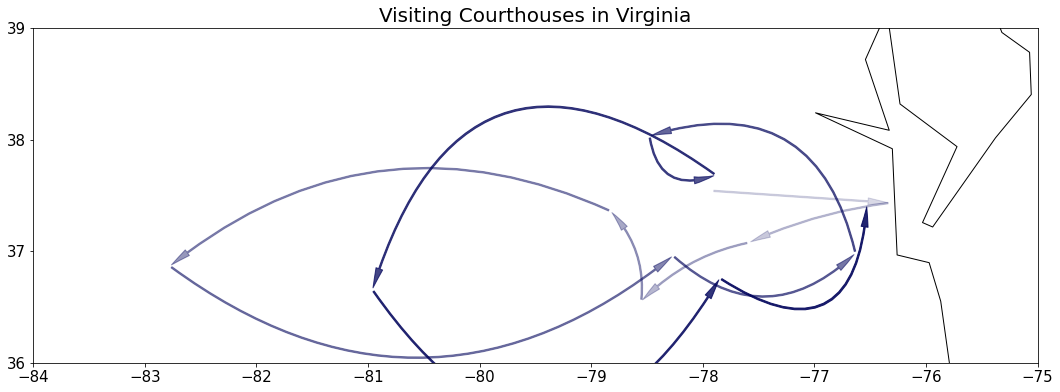

2020-12-07	Powhatan Courthouse Historic District
2020-12-08	Mathews County Courthouse Square
2020-12-12	Dinwiddie County Court House
2020-12-13	Buckingham Courthouse Historic District
2020-12-14	Appomattox Court House
2020-12-15	United States Post Office and Courthouse
2020-12-16	Lunenburg Courthouse Historic District
2020-12-17	Old Isle of Wight Courthouse
2020-12-19	Albemarle County Courthouse Historic District
2020-12-20	Goochland County Court Square
2020-12-22	Old Grayson County Courthouse and Clerk's Office
2020-12-25	Brunswick County Courthouse Square


In [12]:
arrow_map(r.df, 'random_date', 'Lon_Lat_P625', 'gov_building_subclass_P31Label', 'Visiting Courthouses in Virginia')

# Example 2: Twenty Random National Parks in the US

### Create relation

In [13]:
entity_subclass = 'national_park'
qnum = 'Q34918903' # "National Park of the United States"
r = createRelation(qnum, label=True)
r.extend('P31', True, 'entity_subclass', label=True) # extend via property P31 = is instance of

r.changeFocus('entity_subclass_P31')
r.extend('P17', False, 'Country',label=True, search="Q30") # extend via property P17 = is in country
# r.extend('P131', False, 'State', label=True)
r.extend('P625', False, 'Lon_Lat')
r.extend('P571', False, 'Inception')
r.query()

print('There are %s instances of %s in the US.' % (str(len(r.df)), entity_subclass))

There are 77 instances of national_park in the US.


In [14]:
r.df

,Entity ID,entity_subclass_P31,entity_subclass_P31Label,Country_P17,Country_P17Label,Lon_Lat_P625,Inception_P571
0,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q836264,Kobuk Valley National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-159.283333333 67.55),1980-12-02T00:00:00Z
1,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q205952,Hawaiʻi Volcanoes National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-155.12361 19.40083),1916-01-01T00:00:00Z
2,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q841503,Kenai Fjords National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-150.10857 59.81571),1980-01-01T00:00:00Z
3,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q866080,Biscayne National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-80.18096924 25.50185493),1980-06-28T00:00:00Z
4,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q305880,Black Canyon of the Gunnison National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-107.716666666 38.566666666),1933-03-02T00:00:00Z
...,...,...,...,...,...,...,...
72,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q605657,Gates of the Arctic National Park and Preserve,http://www.wikidata.org/entity/Q30,United States of America,Point(-153.3 67.7833),1980-01-01T00:00:00Z
73,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q217136,Denali National Park and Preserve,http://www.wikidata.org/entity/Q30,United States of America,Point(-150.3 63.2),1917-01-01T00:00:00Z
74,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q239304,Crater Lake National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-122.148055555 42.911944444),1902-01-01T00:00:00Z
75,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q129902,Capitol Reef National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-111.167 38.2),1937-08-02T00:00:00Z


### Produce a column of random dates and add them to the dataframe

In [15]:
df = r.df[r.df.Inception_P571!='NA'][:20]

In [16]:
date1 = '2020-12-01'
date2 = '2020-12-31'
quantity = len(df)
random_dates = get_random_dates(date1, date2, quantity)
df['random_date'] = random_dates
df.head()

,Entity ID,entity_subclass_P31,entity_subclass_P31Label,Country_P17,Country_P17Label,Lon_Lat_P625,Inception_P571,random_date
0,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q836264,Kobuk Valley National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-159.283333333 67.55),1980-12-02T00:00:00Z,2020-12-05
1,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q205952,Hawaiʻi Volcanoes National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-155.12361 19.40083),1916-01-01T00:00:00Z,2020-12-17
2,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q841503,Kenai Fjords National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-150.10857 59.81571),1980-01-01T00:00:00Z,2020-12-23
3,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q866080,Biscayne National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-80.18096924 25.50185493),1980-06-28T00:00:00Z,2020-12-29
4,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q305880,Black Canyon of the Gunnison National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-107.716666666 38.566666666),1933-03-02T00:00:00Z,2020-12-16


### Plot

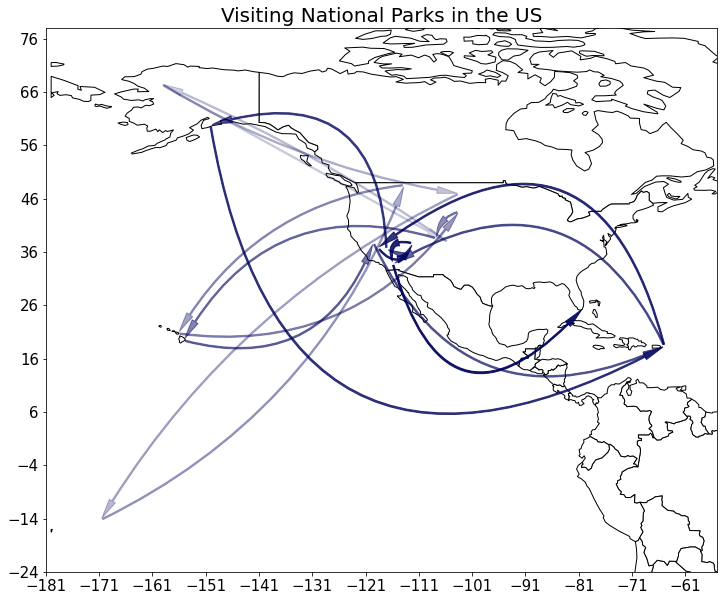

2020-12-01	Kobuk Valley National Park
2020-12-02	Great Sand Dunes National Park and Preserve
2020-12-05	Kobuk Valley National Park
2020-12-06	Theodore Roosevelt National Park
2020-12-09	National Park of American Samoa
2020-12-11	Glacier National Park
2020-12-14	Haleakalā National Park
2020-12-15	Wind Cave National Park
2020-12-16	Black Canyon of the Gunnison National Park
2020-12-17	Hawaiʻi Volcanoes National Park
2020-12-18	Yosemite National Park
2020-12-19	Virgin Islands National Park
2020-12-21	Joshua Tree National Park
2020-12-22	Death Valley National Park
2020-12-23	Kenai Fjords National Park
2020-12-24	Virgin Islands National Park
2020-12-25	Kings Canyon National Park
2020-12-27	Bryce Canyon National Park
2020-12-28	Joshua Tree National Park


In [17]:
arrow_map(df, 'random_date', 'Lon_Lat_P625', 'entity_subclass_P31Label', 'Visiting National Parks in the US')

## Use the National Park's "Inception" date instead

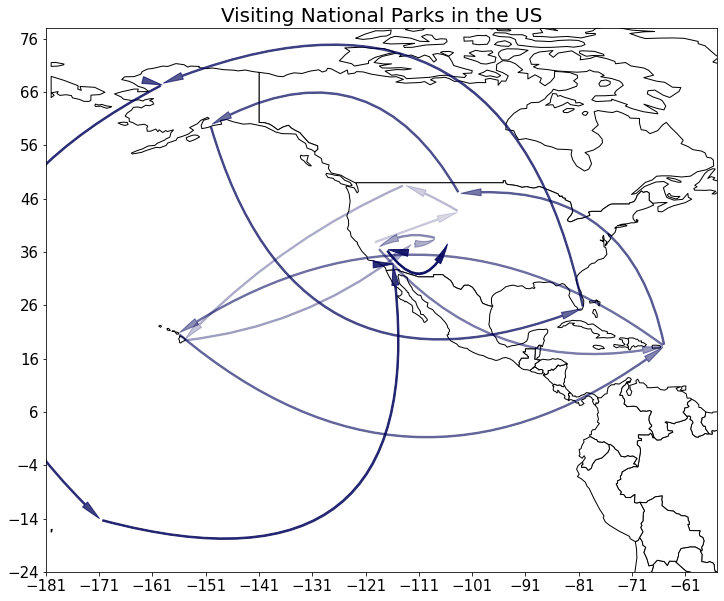

1890-10-01	Yosemite National Park
1903-01-01	Wind Cave National Park
1910-05-11	Glacier National Park
1916-01-01	Hawaiʻi Volcanoes National Park
1928-09-15	Bryce Canyon National Park
1933-03-02	Black Canyon of the Gunnison National Park
1940-01-01	Kings Canyon National Park
1956-08-02	Virgin Islands National Park
1961-07-01	Haleakalā National Park
1976-01-01	Virgin Islands National Park
1978-01-01	Theodore Roosevelt National Park
1980-01-01	Kenai Fjords National Park
1980-06-28	Biscayne National Park
1980-12-02	Kobuk Valley National Park
1980-12-02	Kobuk Valley National Park
1988-01-01	National Park of American Samoa
1994-01-01	Joshua Tree National Park
1994-01-01	Joshua Tree National Park
1994-10-31	Death Valley National Park


In [18]:
arrow_map(df, 'Inception_P571', 'Lon_Lat_P625', 'entity_subclass_P31Label', 'Visiting National Parks in the US')

# Example 3: City Halls in Massachusetts

In [20]:
gov_building_subclass = 'city hall'
qnum = 'Q543654'
r = createRelation(qnum, label=True)
r.extend('P31', True, 'gov_building_subclass', label=True) # extend via property P31 = is instance of

r.changeFocus('gov_building_subclass_P31')
r.extend('P17', False, 'Country',label=True, search="Q30") # extend via property P17 = is in country
r.extend('P131', False, 'State', label=True, search="Q771")
r.extend('P625', False, 'Lon_Lat')
r.query()

print('There are %s instances of %s in Massachusetts.' % (str(len(r.df)), gov_building_subclass))

There are 40 instances of city hall in Massachusetts.


In [21]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625
0,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q7569232,Southbridge Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-72.034722 42.073056)
1,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q4754630,Andover Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-71.140278 42.655833)
2,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q7829958,Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-70.950556 41.845833)
3,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q8023864,Winchester Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-71.135 42.4525)
4,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q7899402,Upton Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-71.592222 42.173889)


### Produce a column of random dates and add them to the dataframe

In [22]:
df = r.df[:20]
date1 = '2020-12-01'
date2 = '2020-12-31'
quantity = len(df)
random_dates = get_random_dates(date1, date2, quantity)
df['random_date'] = random_dates
df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,random_date
0,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q7569232,Southbridge Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-72.034722 42.073056),2020-12-17
1,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q4754630,Andover Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-71.140278 42.655833),2020-12-26
2,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q7829958,Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-70.950556 41.845833),2020-12-11
3,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q8023864,Winchester Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-71.135 42.4525),2020-12-10
4,http://www.wikidata.org/entity/Q543654,http://www.wikidata.org/entity/Q7899402,Upton Town Hall,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q771,Massachusetts,Point(-71.592222 42.173889),2020-12-20


### Plot

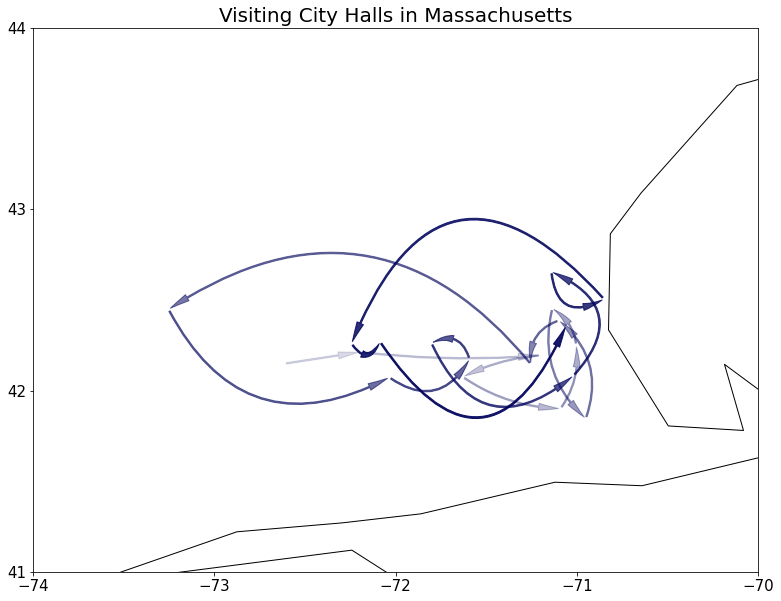

2020-12-02	City Hall
2020-12-04	Warren Town Hall
2020-12-05	Norwood Memorial Municipal Building
2020-12-07	Uxbridge Town Hall
2020-12-08	Taunton City Hall
2020-12-09	Quincy City Hall
2020-12-10	Winchester Town Hall
2020-12-11	Town Hall
2020-12-13	Somerville City Hall
2020-12-14	Walpole Town Hall
2020-12-16	Old Town Hall
2020-12-17	Southbridge Town Hall
2020-12-20	Upton Town Hall
2020-12-21	Worcester City Hall and Common
2020-12-25	Brockton City Hall
2020-12-26	Andover Town Hall
2020-12-27	Old Town House
2020-12-28	Ware Town Hall
2020-12-29	North Brookfield Town House


In [23]:
arrow_map(df, 'random_date', 'Lon_Lat_P625', 'gov_building_subclass_P31Label', 'Visiting City Halls in Massachusetts')

# Example 4: 12 Museums in Michigan

In [24]:
entity_subclass = 'museum'
qnum = 'Q33506' # "museum"
r = createRelation(qnum, label=True)
r.extend('P31', True, 'entity_subclass', label=True) # extend via property P31 = is instance of

r.changeFocus('entity_subclass_P31')
r.extend('P17', False, 'Country',label=True, search="Q30") # extend via property P17 = is in country
r.extend('P131', False, 'State', label=True, search="Q1166")
r.extend('P625', False, 'Lon_Lat')
r.extend('P571', False, 'Inception')
r.query()

print('There are %s instances of %s in Michigan.' % (str(len(r.df)), entity_subclass))

There are 92 instances of museum in Michigan.


In [25]:
df = r.df[r.df.Inception_P571!='NA'][r.df.Lon_Lat_P625!='NA']

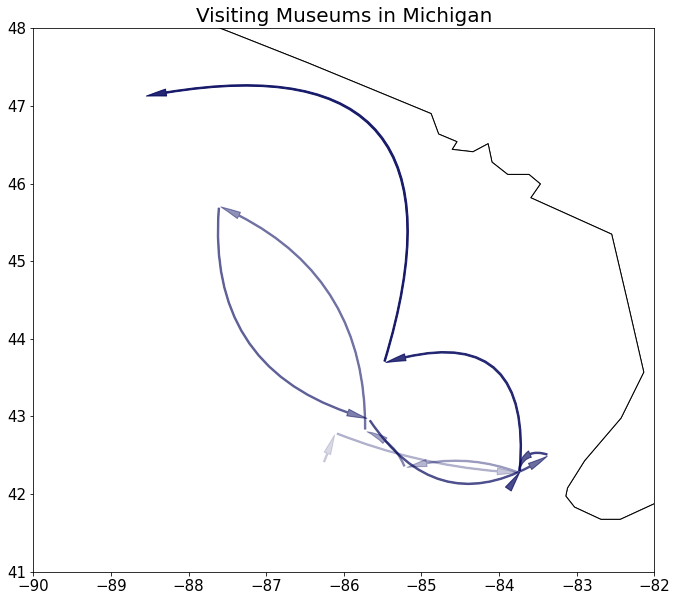

1858-01-01	Bailey Museum
1897-01-01	Holland Museum
1909-01-01	University of Michigan Museum of Art
1934-01-01	Kingman Museum
1978-01-01	Byron Area Historic Museum
1982-01-01	IXL Historical Museum
1982-01-01	Gerald R. Ford Presidential Museum
1984-01-01	Holocaust Memorial Center
1987-01-01	Argus Museum
1991-01-01	Sindecuse Museum of Dentistry
1996-01-01	Jim Crow Museum of Racist Memorabilia


In [26]:
arrow_map(df, 'Inception_P571', 'Lon_Lat_P625', 'entity_subclass_P31Label', 'Visiting Museums in Michigan')

# Example 5: 20 Museums Around the World

In [27]:
entity_subclass = 'museum'
qnum = 'Q33506' # "museum"
r = createRelation(qnum, label=True)
r.extend('P31', True, 'entity_subclass', label=True) # extend via property P31 = is instance of

r.changeFocus('entity_subclass_P31')
r.extend('P625', False, 'Lon_Lat')
r.extend('P571', False, 'Inception')
r.query()

print('There are %s instances of %s in the world.' % (str(len(r.df)), entity_subclass))

There are 40657 instances of museum in the world.


In [28]:
df = r.df[r.df.Inception_P571!='NA'][r.df.Lon_Lat_P625!='NA'][20:40]

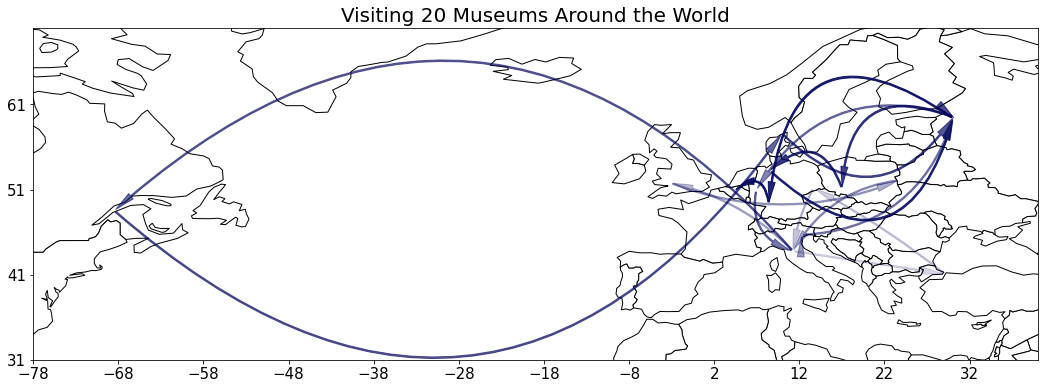

1278-01-01	Basilica of Our Lady
1393-01-01	Anadoluhisarı
1542-01-01	Moritzburg Castle
1560-01-01	Uffizi
1789-01-01	Blaenavon Ironworks
1836-01-01	Brest Fortress
1869-01-01	The Florence Museum of Botanical Natural Science
1879-01-01	Musei civici di Treviso
1918-01-01	Gatchina museum-preserve
1956-01-01	Schnütgen Museum
1970-01-01	Belvedere
1980-01-01	Site historique maritime de la Pointe-au-Père
1984-01-01	Nordsøen Oceanarium
1992-01-01	Shcherbov House, Gatchina
1999-01-01	Suyda
2000-01-01	City Museum of Wrocław
2007-01-01	Barrack Wilhelmine
2009-01-01	Q50895
2010-01-01	Museum SchPIRA


In [29]:
arrow_map(df, 'Inception_P571', 'Lon_Lat_P625', 'entity_subclass_P31Label', 'Visiting 20 Museums Around the World')